## Imports and installs

In [1]:
#for ml
import os
import torch

#for audio
import librosa
import torchaudio


os.environ['KERAS_BACKEND']='torch'

import keras


## Create dataset

In [2]:
import pandas as pd
data = pd.read_csv('adc_speakers_rough.csv')

In [3]:
labeldict = {index: element for index, element in enumerate(data['label'].unique())}

def id2label(vec):
    for i in range(len(labeldict)):
        if labeldict[i]==vec:
            if os.environ['KERAS_BACKEND']=='torch':
                return torch.Tensor([i])            
            else:
                return tf.convert_to_tensor([i])

id2label('00-felipe')

tensor([0.])

In [4]:
#using pytorch Dataset and Dataloader

from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,path,label):
        self.path = path
        self.label = label
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,index):
        audio_path = self.path[index]
        speech,sample_rate = librosa.load(audio_path)
        resampler = torchaudio.transforms.Resample(orig_freq = sample_rate)
        speech = resampler.forward(torch.Tensor(speech))
        sample_rate = 16000
        label = id2label(self.label[index])

        return audio_path,speech,sample_rate,label


In [5]:
BATCH_SIZE = 4

In [6]:
#split train and test

import numpy as np


percent = 0.8

shuffled_indices = np.random.permutation(len(data))

split = int(percent*len(data))

print(split)

train_indices = shuffled_indices[:split]
val_indices = shuffled_indices[split:]

data_train = data.iloc[train_indices].reset_index(drop=True)
data_val = data.iloc[val_indices].reset_index(drop=True)


train_dataset = AudioDataset(data_train['path'],data_train['label'])
val_dataset = AudioDataset(data_val['path'],data_val['label'])

1031


In [20]:
from torch.nn.functional import pad

transform = torchaudio.transforms.Spectrogram(n_fft=512)

def collate_fn(batch):
    #print(batch)
    path, waveforms, sample_rates, label = zip(*batch)
    # Calculate the maximum length within this batch
    max_length = max(len(waveform) for waveform in waveforms)
    #print(f'max_length = {max_length}')
    # Pad all sequences to match the maximum length
    padded_waveforms = torch.stack([torch.transpose(transform(pad(waveform,(0, max_length - len(waveform)), mode='constant', value=0)),0,1) for waveform in waveforms])
    
    #fft
    padded_waveforms = torch.unsqueeze(padded_waveforms,-1)
    
    #print(f'length of the largest audio: {len(padded_waveforms[0])}')
    
    return padded_waveforms,torch.stack(label)



In [21]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


for batch_idx, (audio_batch, label_batch) in enumerate(train_dataloader):
    print(f"Batch #{batch_idx}")
    print(f"\tAudio batch:\n{audio_batch.shape}\n")
    print(f"\tLabel batch:\n{label_batch}\n")
    break

Batch #0
	Audio batch:
torch.Size([4, 458, 257, 1])

	Label batch:
tensor([[0.],
        [3.],
        [0.],
        [1.]])



## Create model

In [22]:
layers_num = 4


inputs = keras.Input(shape=(None,257,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x) 
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = keras.layers.MaxPooling2D(pool_size=2)(x) 
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(5,'softmax')(x)

model_fft = keras.Model(inputs=inputs,outputs=outputs)

model_fft.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, 257, 1)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, 255, 32)     │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, 127, 32)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, 125, 64)     │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, None, 62, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, 60, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 128)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 5)                 │        645 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 93,317 (364.52 KB)

 Trainable params: 93,317 (364.52 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_fft.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model_fft.fit(train_dataloader,
                     validation_data=val_dataloader,
                     epochs=10,
                     batch_size=BATCH_SIZE)

Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 234s 908ms/step - accuracy: 0.4133 - loss: 1.2755 - val_accuracy: 0.8876 - val_loss: 0.4057
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 238s 925ms/step - accuracy: 0.8485 - loss: 0.4482 - val_accuracy: 0.8682 - val_loss: 0.3610
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 240s 929ms/step - accuracy: 0.9352 - loss: 0.2181 - val_accuracy: 0.9535 - val_loss: 0.1596
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 245s 953ms/step - accuracy: 0.9060 - loss: 0.2552 - val_accuracy: 0.9612 - val_loss: 0.1302
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 234s 909ms/step - accuracy: 0.9639 - loss: 0.1265 - val_accuracy: 0.9380 - val_loss: 0.2366
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 200s 774ms/step - accuracy: 0.9340 - loss: 0.2163 - val_accuracy: 0.9574 - val_loss: 0.1414
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 198s 768ms/step - accuracy: 0.9645 - loss: 0.1278 - val_accuracy: 0.9302 - val_loss: 0.2414
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 183s 712ms/step - accuracy: 0.9437 -

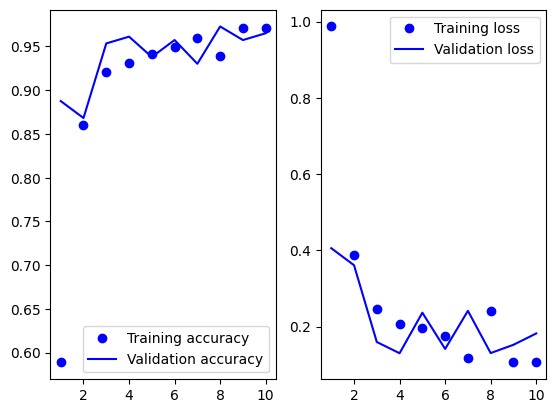

In [24]:
import matplotlib.pyplot as plt 
accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 

epochs = range(1, len(accuracy) + 1) 

plt.subplot(121)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.legend()


## Save model

In [27]:
model_fft.save('model_fft.keras')

In [28]:
testmodel = keras.saving.load_model('model_fft.keras', custom_objects=None, compile=True, safe_mode=True)

testmodel.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, 257, 1)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, 255, 32)     │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, 127, 32)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, 125, 64)     │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, None, 62, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, 60, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 128)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 5)                 │        645 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 279,953 (1.07 MB)

 Trainable params: 93,317 (364.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 186,636 (729.05 KB)

In [29]:
testmodel.evaluate(val_dataloader)

65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 498ms/step - accuracy: 0.9690 - loss: 0.1479


[0.1713522970676422, 0.9651162624359131]